In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# Overview

This project explores how to use WENO reconstruction (first described in [this paper](https://www.sciencedirect.com/science/article/pii/S0021999184711879)) to solve the 1D Euler gas equations.

The Euler gas equations can be written as a system of hyperbolic 1D equations, as described in several places, e.g.[here](http://www.clawpack.org/riemann_book/html/Euler.html#:~:text=Hyperbolic%20structure%20of%20the%201D%20Euler%20equations&text=q%3D(%CF%81%CF%81uE,the%20one%2Ddimensional%20Euler%20system.).

In this form they are like a coupled system of three conservation laws in density (which we'll call "r"), pressure (p), and velocity (u).

One way to use WENO to solve the euler equations is as described [here](http://math.tifrbng.res.in/~praveen/pub/ncm2019.pdf), by projecting into the characteristics, then WENO reconstructing, and then using these estimates with Local-Lax-Friedrichs fluxes to get the values we're interested in.

We test on simple linear advection, i.e. when the density as a function of x is a sinusoid (1 + 0.5 sin(2pix)), and the initial pressure and energy are some constant everywhere. Under these conditions the pressure and velocity should never change and the density is advected, returning periodically to the initial distribution. The code here tests the dependence of the error on spacing to confirm that WENO reconstruction gives us 3rd order accuracy.

The more intriguing case we test is the Sod problem, described [here](https://www.astro.uu.se/~hoefner/astro/teach/ch10.pdf). The problem basically simulates what happens in a close tube when two regions of different pressure that were once separated are suddenly freely allowed to interact. We get a shock wave and the expected solutions are described in the previous link. We graph the solutions obtained by our solver and observe that the answers we get are correct.

## Physics helper functions and WENO reconstruction

We next implement necessary functions to define the relationships between the physical quantities in question and set up the WENO reconstruction, Local-Lax-Friedrichs flux function, and a 3rd order runge-kutta solver for the problem.

In [2]:
#Define F on the *primitive* variables
#R/Rinv is the similarity transform to get to the characteristics
#helper functions:

#the function F for which the equations look like u_t + (F(u))x = 0
def F(u):
    #u is a vector of 3-tuples, (density, density*velocity, energy)
    r = u[0] #density
    ru = u[1] #density*velocity
    e = u[2] #energy
    retval = np.zeros(3,dtype=np.float64)
    gam = 1.4 #adiabatic constant for a diatomic gas, like typical air
    p = (gam - 1)*(e - 0.5*r*(ru/r)**2) #caloric equation of state (How pressure is related to e,r,u)
    
    #returning the 3-tuple that makes the equations look like conservation laws
    retval[0] = ru
    retval[1] = p + r*(ru/r)**2
    retval[2] = (e + p)*(ru/r)
    return retval

#This is the transformation that takes the given tuples into the form of the characteristics
#I'm just following the physics here too..
def R(u):
    #extracting density, density*velocity, energy as before
    r = u[0]
    ru = u[1]
    e = u[2]
    gam = 1.4
    p = (gam - 1)*(e - 0.5*r*(ru/r)**2) #caloric equation of state (finding pressure)
    a = (gam*p/r)**0.5 #speed of sound in the medium
    u = ru/r #velocity
    H = (e + p)/r #enthalpy
    retval = np.zeros((3,3),dtype=np.float64)
    #returning the expected characteristics as a chance of basis matrix
    retval[0] = np.array([1.0,1.0,1.0])
    retval[1] = np.array([u-a,u,u+a])
    retval[2] = np.array([H - u*a, 0.5*u**2, H + u*a])
    return retval

#the inverse of this transform, necessary in other places
def Rinv(u):
    retval = la.inv(R(u))
    return retval

In [3]:
#a helper function that extracts the quantities r (density), u (velocity), p (pressure), E (energy)
#when given a vector
def get_rupe(u):
    gam = 1.4 #adiabatic constant for diatomic gas
    r = u[0,:] #density
    ru = u[1,:] #density*velocity
    E = u[2,:] #energy
    u = np.multiply(ru,r**-1.0) #velocity
    p = (gam - 1)*(E - 0.5*np.multiply(r,u**2)) #caloric equation of state - pressure
    return r,u,p,E

In [4]:
#the WENO reconstruction function, which takes cell averages and returns the "winded" averages
#the reason for the numbers being what they are is carefully explained in the original paper and the reference
#basically, interpolating this way gives us reconstructions that are 3rd-order accurate, based on taylor considerations etc
def weno3(v0,v1,v2,d):
    #v0, v1, v2 are the three estimates from three different stencils around the point in question
    #d is the derivative which helps us decide which way to weight - the reason for this is subtle, explained in the paper
    #using d correctly gives us another order of accuracy for free..
    p0 = 1.5*v1 - 0.5*v0 #"polynomials" - but evaluated at the point
    p1 = 0.5*(v1 + v2)
    b0 = (v1 - v0)**2 #smoothing factors
    b1 = (v2 - v1)**2
    eps = 1e-7
    retval = np.zeros(3,dtype=np.float64)
    for i in range(3): #combining in the required magic ratios for third order accuracy
        if d[i] >= 0: 
            a0 = 0.5/((eps + b0[i])**2)
            a1 = 1.0/((eps + b1[i])**2)
            retval[i] = (a0*p0[i] + a1*p1[i])/(a0 + a1)
        else:
            a0 = 1.0/((eps + b0[i])**2)
            a1 = 0.5/((eps + b1[i])**2)
            retval[i] = (a0*p0[i] + a1*p1[i])/(a0 + a1)
    return retval

#a helper function that calculates velocity and the speed of sound in a given medium, useful elsewhere
def get_ua(u):
    r = u[0]
    ru = u[1]
    e = u[2]
    gam = 1.4
    p = (gam - 1)*(e - 0.5*r*(ru/r)**2) #caloric equation of state
    a = (gam*p/r)**0.5 #speed of sound in the medium
    u = ru/r #velocity
    return u, a

#will be done using the characteristics
#this is the all important reconstruction function, that computes the characteristics and stencils
#and then passes them to the WENO3 function to get 3rd order estimates. Then it undoes the characteristic
#transformation and passes the left and right cell estimates to the Lax-Friedrichs function, along with
#information about the derivative everywhere (which is necessary)
def reconstruct(u,b):
    n = u.shape[1]
    ul = np.zeros((3,n+1),dtype=np.float64) #the left endpoints for lax friedrichs
    ur = np.zeros((3,n+1),dtype=np.float64) #the right endpoint for lax friedrichs
    lams = np.zeros(n+1,dtype=np.float64) #where we will store information about the derivatives
    for i in range(n+1): #at cell i, we need four points around it to get three stencils of three points each
        indl = i - 2 #index of point to the left
        ind = i - 1 #index of the point
        indr = i #index of the point to the right
        indr2 = i+1 #index of point two steps to the right
        
        #handling periodic boundary conditions - basically moving modulo n when we fall off any end
        if indl < 0:
            if b == "p":
                indl = indl + n
            else:
                continue
        if ind < 0:
            if b == "p":
                ind = ind + n
            else:
                continue
        if indr >= n:
            if b == "p":
                indr = indr - n
            else:
                continue
        if indr2 >= n:
            if b == "p":
                indr2 = indr2 - n
            else:
                continue

        #with characteristics
        u_h = 0.5*(u[:,ind] + u[:,indr]) #getting an average around the point
        r_h = R(u_h) #the characteristic matrix, defining a local linear transformation from chars to u
        l_h = Rinv(u_h) #the inverse matrix, which goes from u to chars
        
        #the characteristic speeds at the point are u-a, u, u + a, u = velocity, a = speed of sound at the point
        #the maximum of these speeds is information we need for the lax-friedrichs function later
        left_u, left_a = get_ua(u[:,ind])
        right_u, right_a = get_ua(u[:,indr])
        dl = np.array([left_u - left_a, left_u, left_u + left_a])
        dr = np.array([right_u - right_a, right_u, right_u + right_a])
        
        #now weno reconstructing on the characteristics using the inverse transformation that takes us into char space
        w0 = np.dot(l_h,u[:,indl])
        w1 = np.dot(l_h,u[:,ind])
        w2 = np.dot(l_h,u[:,indr])
        w3 = np.dot(l_h,u[:,indr2])
        ret1 = weno3(w0,w1,w2,dl) #3rd order WENO function for the left estimate
        ret2 = weno3(w3,w2,w1,dr) #3rd order WENO for the right estimate
        
        #undoing the coordinate transformation back into local coordinates
        ul[:,i] = np.dot(r_h,ret1)
        ur[:,i] = np.dot(r_h,ret2)
        lams[i] = np.max(np.array([np.max(np.abs(dl)),np.max(np.abs(dr))])) #remembering max char speed for LLF

    #last but not least, apart from periodic conditions, we have Neumann conditions
    #this is a standard taylor approximation based construction accurate to third order
    if b == "n":
        ul[:,0] = (4*ul[:,2] - ul[:,4])/3
        ul[:,1] = (3*ul[:,0] + ul[:,2])/4
        
        ur[:,0] = (4*ur[:,2] - ur[:,4])/3
        ur[:,1] = (3*ur[:,0] + ur[:,2])/4
        
        ul[:,n] = (4*ul[:,n-3] - ul[:,n-6])/3
        ul[:,n-2] = (3*ul[:,n] + ul[:,n-4])/4
        ul[:,n-1] = (3*ul[:,n] + ul[:,n-2])/4
        
        ur[:,n] = (4*ur[:,n-3] - ur[:,n-6])/3
        ur[:,n-2] = (4*ur[:,n] - ur[:,n-4])/3
        ur[:,n-1] = (3*ur[:,n] + ur[:,n-2])/4
        
        lams[0] = np.max(lams)
        lams[1] = lams[0]
        lams[n] = lams[0]
        lams[n-1] = lams[0]
        
    return ul, ur, lams

In [5]:
#the local lax-friedrichs function, which computes flux values at interfaces
#this is standard, ul = u-, ur = u+ as in most descriptions
def LLFs(u,b):
    ul, ur, lams = reconstruct(u,b)
    f_ur = np.apply_along_axis(F,0,ur)
    f_ul = np.apply_along_axis(F,0,ul)
    diffs = 0.5*np.multiply(lams,ur - ul)
    retval = 0.5*(f_ur + f_ul) - diffs
    return retval, np.max(lams) #the maximum derivative is needed for Local Lax Friedrich's combination parameter

In [6]:
#L = difference of the lax friedrichs function at adjacent points
#typically the hyperbolic conservation law equation is just u_new = u + param*(L), here lam = param
def L(u,b):
    ns = u.shape[1]
    dx = 1.0/ns
    f, lam = LLFs(u,b)
    retval = -1.0*(f[:,1:] - f[:,0:-1])/dx
    return retval, lam

In [7]:
#standard 3-order RK method
#finally using the L function above in this standard multi stage Runge-Kutta method
#following standard rules, using the u = u_old + lam*L finite volume equation
def solve(ics, b, t):
    T = 0
    u = np.copy(ics)
    n = u.shape[1]
    dx = 1.0/n
    while T < t:
        L0, lam = L(u,b)
        dt = min(1.0/(n*lam),1.0/n)
        u1 = u + dt*L0
        L1, lam = L(u1,b)
        u2 = 0.75*u + 0.25*(u1 + dt*L1)
        L2, lam = L(u2,b)
        u = (u/3.0) + 2*(u2 + dt*L2)/3.0
        T = T + dt
    return u

## Defining initial conditions

We make initial conditions for both the sod problem and the advection problem.

For advection density varies as 1 + 0.5 sin(2pi\*x) over the tube, and velocity, energy are some constant.
Our vector is (density, density\*velocity, energy) in the primitive variables

For the sod problem density "r" is two constant regions with an abrupt drop between them, u = 0, and energy abruptly shifts between the two regions two (related to pressure by \*1/gam-1 because u = 0 etc).

In [8]:
def make_per_ics(n):
    gam = 1.4
    retval = np.zeros((3,n),dtype=np.float64)
    retval[0] = 1.0 + 0.5*np.sin(2*np.pi*np.linspace(0,1,n, endpoint=False))
    retval[1] = 1.0 + 0.5*np.sin(2*np.pi*np.linspace(0,1,n, endpoint=False))
    retval[2] = 1.0/(gam - 1) + 0.5*retval[0]
    return retval

In [9]:
def make_sod_ics(n):
    gam = 1.4
    retval = np.zeros((3,n),dtype=np.float64)
    ps = np.linspace(0,1,n) #changed from 0 to 1
    retval[0] = np.array([0.125 if v > 0.5 else 1.0 for v in ps])
    retval[2] = np.array([0.1 if v > 0.5 else 1.0 for v in ps])*1.0/(gam - 1)
    return retval

## Solving the Sod problem

Now we finally solve the Sod problem with our solver. The expected solutions are shown [here](https://www.astro.uu.se/~hoefner/astro/teach/ch10.pdf). I do not determine order of accuracy here because the shocks are hard to deal with. I check order for the advection problem in the next code snippet, though. In all this takes about 10-15 seconds to run.

Running solver... (takes about 10 s)
Done!


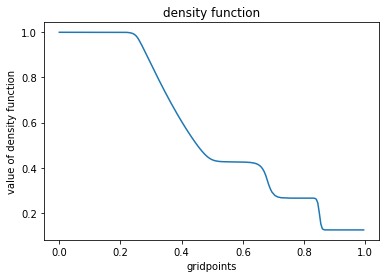

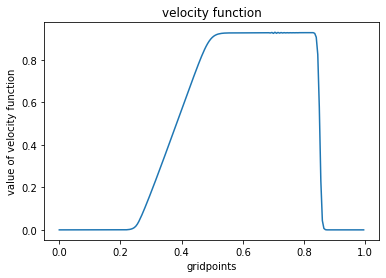

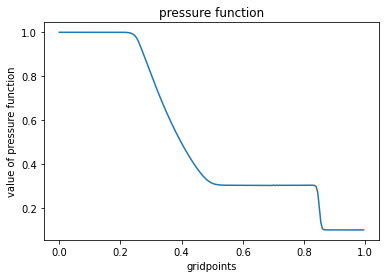

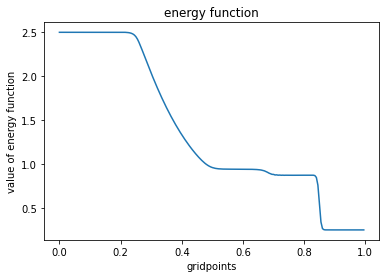

<Figure size 432x288 with 0 Axes>

In [10]:
n = 200
#hs = []
#errs_inf = []
for i in range(1):
    sod_ics = make_sod_ics(n)
    print("Running solver... (takes about 10 s)")
    sol = solve(sod_ics,"n",0.2)
    print("Done!")
    r, u, p, E = get_rupe(sol)
    #r_e, u_e, p_e, E_e = get_rupe(p_ics)
    #errs_inf.append(la.norm(r- r_e,np.inf)*1.0/n)
    vs = np.linspace(0,1,n,endpoint=False)
    plt.plot(vs,r)
    plt.xlabel("gridpoints")
    plt.ylabel("value of density function")
    plt.title("density function")
    plt.figure()
    plt.plot(vs,u)
    plt.xlabel("gridpoints")
    plt.ylabel("value of velocity function")
    plt.title("velocity function")
    plt.figure()
    plt.plot(vs,p)
    plt.xlabel("gridpoints")
    plt.ylabel("value of pressure function")
    plt.title("pressure function")
    plt.figure()
    plt.plot(vs,E)
    plt.xlabel("gridpoints")
    plt.ylabel("value of energy function")
    plt.title("energy function")
    plt.figure()
    #errs_1.append(la.norm(r - r_e,1)*1.0/n)
    #hs.append(1.0/n)
    n = n*2

#plt.loglog(hs,errs_inf, label="observed")
#plt.loglog(hs,np.array(hs)**3,label="expected")
#plt.loglog(hs,np.array(hs)**2,label="order-2")
#plt.loglog(hs,np.array(hs),label="order-1")
#plt.legend()
#plt.xlabel("Value of x-spacing")
#plt.ylabel("infinity norm error")
#plt.title("Plot of infinity-norm errors obtained vs Grid spacing")
#plt.show()

## Verifying accuracy on Advection

Finally we tested whether the solution on advection is third order accurate.
I divide the interval into 100, 200, and 400 points and then create a log plot of the errors obtained.
The reader is reminded that accuracy is measured by the slope of the plot line and not by the absolute location in the graph. Running this code should produce the expected slope and it should be visibly almost parallel to third order error, steeper than both order 1 and 2 even if it overlaps absolutely with any of them.
The time it takes depends roughly quadratically on grid spacing. On average the 100 points take 5 seconds, 200 points take 20 seconds, and 400 points take 80 seconds, for a total of about 2 minutes.

Solving when grid spacing is 100
Solving when grid spacing is 200
Solving when grid spacing is 400


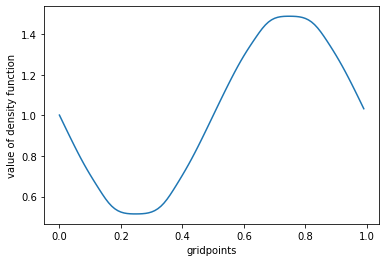

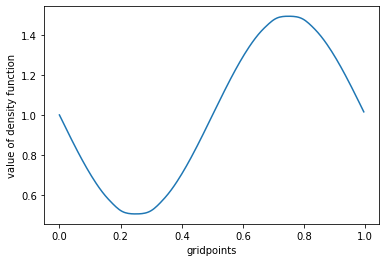

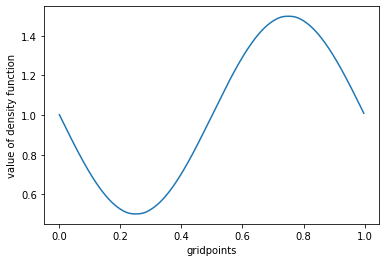

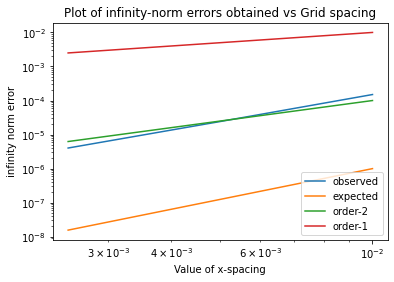

In [11]:
n = 100
hs = []
errs_inf = []
for i in range(3):
    p_ics = make_per_ics(n)
    print("Solving when grid spacing is " + str(n))
    sol = solve(p_ics,"p",0.5) #initial and exact should be the same in this case
    r, u, p, E = get_rupe(sol)
    r_e, u_e, p_e, E_e = get_rupe(p_ics)
    errs_inf.append(la.norm(r - (2.0-r_e),np.inf)*1.0/n) #after half a period, density is just 2 - initial
    vs = np.linspace(0,1,n,endpoint=False)
    plt.plot(vs,r)
    plt.xlabel("gridpoints")
    plt.ylabel("value of density function")
    plt.figure()
    #errs_1.append(la.norm(r - r_e,1)*1.0/n)
    hs.append(1.0/n)
    n = n*2


plt.loglog(hs,errs_inf, label="observed")
plt.loglog(hs,np.array(hs)**3,label="expected")
plt.loglog(hs,np.array(hs)**2,label="order-2")
plt.loglog(hs,np.array(hs),label="order-1")
plt.legend()
plt.xlabel("Value of x-spacing")
plt.ylabel("infinity norm error")
plt.title("Plot of infinity-norm errors obtained vs Grid spacing")
plt.show()